In [133]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

import thinkstats2
import thinkplot
import pandas
import numpy as np
import statsmodels.formula.api as smf

df = pandas.read_csv("games.csv")

## Variabels

In [13]:
list(df.columns)

['Name', 'YearPublished', 'GameWeight', 'AvgRating', 'MaxPlayers']

## Histograms

array([[<AxesSubplot:title={'center':'YearPublished'}>,
        <AxesSubplot:title={'center':'GameWeight'}>],
       [<AxesSubplot:title={'center':'AvgRating'}>,
        <AxesSubplot:title={'center':'MaxPlayers'}>]], dtype=object)

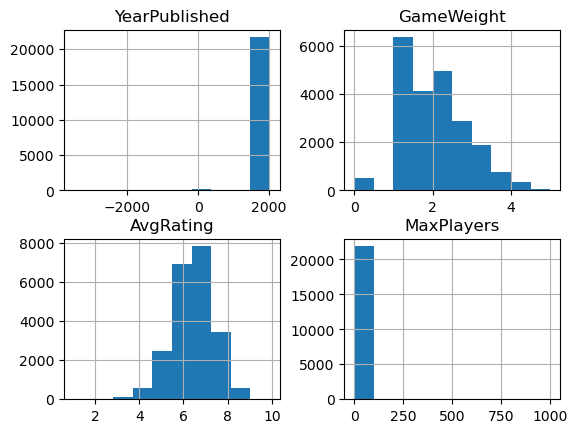

In [19]:
hist = thinkstats2.Hist(df.YearPublished, label="Year_Published")
df.hist()

In [24]:
df = df.drop(df[df.YearPublished < 1950].index)
df = df.drop(df[df.MaxPlayers > 20].index)
df = df.drop(df[df.MaxPlayers == 0].index)
df = df.drop(df[df.GameWeight == 0].index)

array([[<AxesSubplot:title={'center':'YearPublished'}>,
        <AxesSubplot:title={'center':'GameWeight'}>],
       [<AxesSubplot:title={'center':'AvgRating'}>,
        <AxesSubplot:title={'center':'MaxPlayers'}>]], dtype=object)

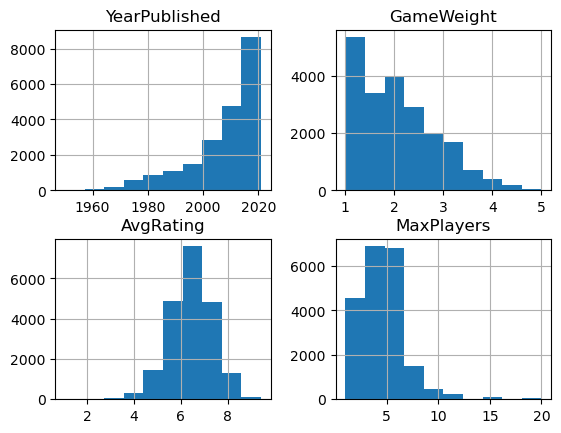

In [25]:
hist = thinkstats2.Hist(df.YearPublished, label="Year_Published")
df.hist()

## Characteristics

In [22]:
 def gatherChars(data):
    mean = data.mean()
    mode = data.mode()
    var = data.var()
    return [mean,mode,var]

In [23]:
year_chars = gatherChars(df.YearPublished)
weight_chars = gatherChars(df.GameWeight)
rate_chars = gatherChars(df.AvgRating)
player_chars = gatherChars(df.MaxPlayers)

In [91]:
for char in year_chars:
    print(char)

1985.4949144811858
0    2017
Name: YearPublished, dtype: int64
45150.391200641425


In [92]:
for char in weight_chars:
    print(char)

1.9821310877993088
0    1.0
Name: GameWeight, dtype: float64
0.72077179212238


In [93]:
for char in rate_chars:
    print(char)

6.424922447434443
0    6.5
Name: AvgRating, dtype: float64
0.8695140718595993


In [94]:
for char in player_chars:
    print(char)

5.707867730900798
0    4
Name: MaxPlayers, dtype: int64
225.43951344714614


## PMF

In [47]:
less_complex = thinkstats2.Pmf(df[df.GameWeight <= df.GameWeight.mean()].YearPublished , label="Less Complex")
more_complex = thinkstats2.Pmf(df[df.GameWeight > df.GameWeight.mean()].YearPublished , label="More Complex")

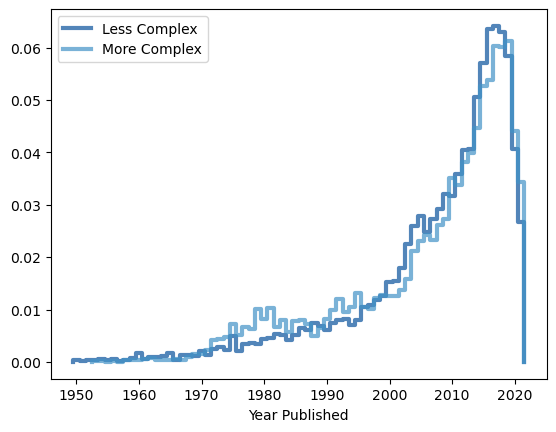

In [48]:
thinkplot.PrePlot(2)
thinkplot.Pmfs([less_complex, more_complex])
thinkplot.Config(xlabel="Year Published")

# CDF

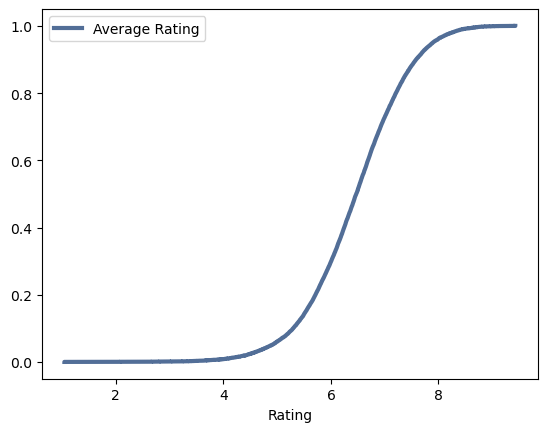

In [55]:
cdf = thinkstats2.Cdf(df.AvgRating, label = "Average Rating")
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel="Rating")

## CCDF

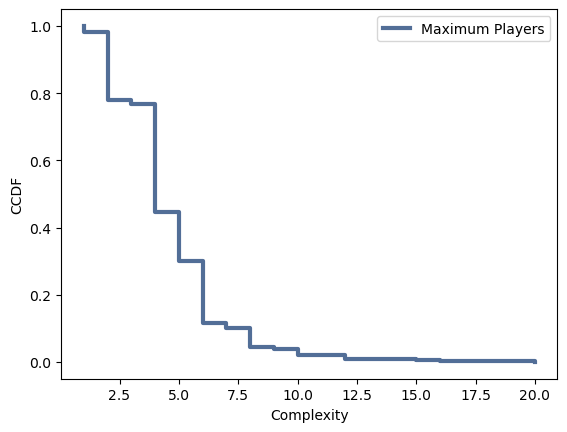

In [65]:
cdf = thinkstats2.Cdf(df.MaxPlayers, label = "Maximum Players")
thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(
    xlabel="Complexity",
    ylabel="CCDF",
    yscale="linear",
    loc="upper right",
)

In [67]:
df[df.MaxPlayers > 8].GameWeight.mean()

1.5352990990991002

## Scatterplots

In [76]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample
sample = SampleRows(df, 5000)

In [89]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

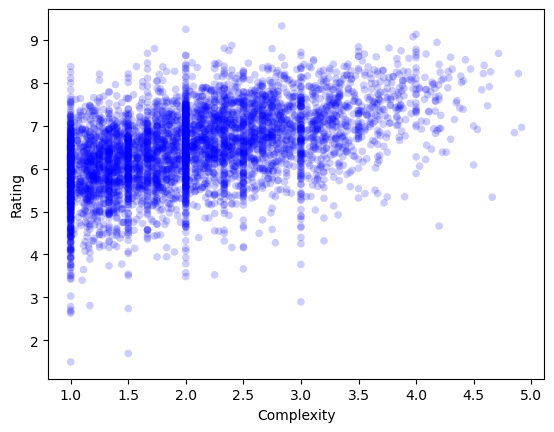

In [85]:
thinkplot.Scatter(sample.GameWeight, sample.AvgRating, alpha=0.2)
thinkplot.Config(xlabel='Complexity',
                 ylabel='Rating')

In [88]:
Cov(df.GameWeight, df.AvgRating)

0.37411531026309586

In [90]:
Corr(df.GameWeight, df.AvgRating)

0.509390361028295

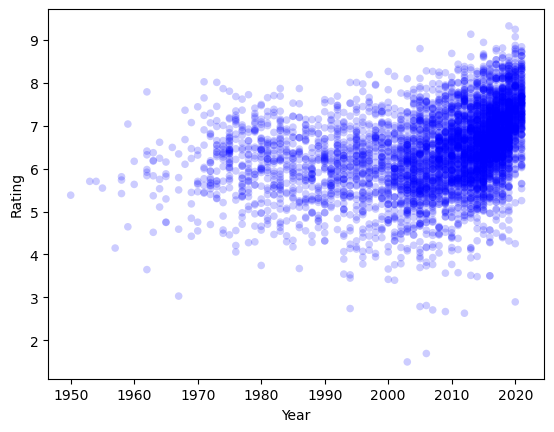

In [83]:
thinkplot.Scatter(sample.YearPublished, sample.AvgRating, alpha=0.2)
thinkplot.Config(xlabel='Year',
                 ylabel='Rating')

In [91]:
Cov(df.YearPublished, df.AvgRating)

3.998119252355028

In [110]:
Corr(df.YearPublished, df.AvgRating)

0.34299084974625926

In [93]:
Corr(df[df.YearPublished > 2000].YearPublished, df[df.YearPublished > 2000].AvgRating)

0.40513546956120156

## Correlation Testing

In [128]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [124]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [131]:
data = df.YearPublished.values, df.AvgRating.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

In [132]:
ht.actual, ht.MaxTestStat()

(0.34299084974625926, 0.02540002636042231)

In [109]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.0

## Regression

In [156]:
df_2000 = df[df.YearPublished > 2000]

In [158]:
formula = 'AvgRating ~ YearPublished'
model = smf.ols(formula, data=df_2000)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              AvgRating   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     3124.
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:41:21   Log-Likelihood:                -20700.
No. Observations:               16718   AIC:                         4.140e+04
Df Residuals:                   16716   BIC:                         4.142e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -127.6566      2.401    -53.161      0.000    -132.363    -122.950
YearPublished     0.0667      0.001     55.891      0.000       0.064       0.069
==============================================================================
Omnibus:                      713.390   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1289.692
Skew:                          -0.342   Prob(JB):                    8.85e-281
Kurtosis:                       4.176   Cond. No.                     7.49e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""